# 데이터 전처리

In [83]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
# sns.set()
# sns.set_style("whitegrid")
# sns.set_color_codes()
# %matplotlib inline
# plt.rcParams["figure.figsize"] = (8,6)
# plt.rcParams["figure.dpi"] = 80
# plt.rcParams["font.family"] = "D2Coding"
from sklearn.model_selection import train_test_split
import folium
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

In [16]:
df = pd.read_csv("noshow.csv")

In [17]:
region_weather = pd.read_csv("region_weather.csv")
region_weather.tail()

,region,temperature,time,weather
2171,CENTRO,14.905556,1.462493e+09,Clear
2172,SÃO BENEDITO,28.127778,1.465258e+09,Humid
2173,ITARARÉ,11.816667,1.465258e+09,Mostly Cloudy
2174,SANTA CLARA,9.900000,1.465258e+09,Partly Cloudy
2175,CENTRO,9.955556,1.465258e+09,Partly Cloudy


In [18]:
import time
region_weather.time = region_weather.time.apply(lambda x: time.strftime("%Y-%m-%d", time.localtime(int(x))))

### 날짜형식 범주형 변수로 바꿔주기

In [19]:
df["Scheduled_date"] = df["ScheduledDay"].apply(lambda x: x[:10])
df['Scheduled_date'] = pd.to_datetime(df['Scheduled_date'])
df['Scheduled_time'] = df['ScheduledDay'].apply(lambda x: x[11:-1])
df['Scheduled_time'] = pd.to_timedelta(df['Scheduled_time'])
df['Appointment_date'] = df['AppointmentDay'].apply(lambda x: x[:10])
df['Appointment_date'] = pd.to_datetime(df['Appointment_date'])
df['Appointment_time'] = df['AppointmentDay'].apply(lambda x: x[11:-1])
df['Appointment_time'] = pd.to_timedelta(df['Appointment_time'])
df = df.drop(columns = "Appointment_time")

In [20]:
df["date_diff"] = df.Appointment_date - df.Scheduled_date

In [21]:
df.date_diff = df.date_diff.apply(lambda x: int(str(x).split("days")[0]))

### PatientId, Handcap 범주형 변수로 바꾸기

In [22]:
df.Handcap = pd.Categorical(df.Handcap)

### Age가 음수이거나 date_diff가 음수인 데이터 빼주기

In [23]:
df = df[df.Age >= 0]

In [24]:
df = df[df.date_diff >= 0]

In [25]:
df.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled_date,Scheduled_time,Appointment_date,date_diff
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No,2016-05-03,09:15:35,2016-06-07,35
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No,2016-05-03,07:27:33,2016-06-07,35
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No,2016-04-27,16:03:52,2016-06-07,41
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No,2016-04-27,15:09:23,2016-06-07,41
110526,3.775115e+14,5629448,F,2016-04-27T13:30:56Z,2016-06-07T00:00:00Z,54,MARIA ORTIZ,0,0,0,0,0,1,No,2016-04-27,13:30:56,2016-06-07,41


In [26]:
df.corr()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,date_diff
PatientId,1.000000,0.004019,-0.004192,-0.002873,-0.006431,0.001612,0.011016,-0.009735,-0.001442
AppointmentID,0.004019,1.000000,-0.019109,0.022620,0.012760,0.022633,0.032947,-0.256614,-0.771840
Age,-0.004192,-0.019109,1.000000,-0.092469,0.504599,0.292398,0.095811,0.012629,0.034813
Scholarship,-0.002873,0.022620,-0.092469,1.000000,-0.019738,-0.024899,0.035019,0.001182,-0.030435
Hipertension,-0.006431,0.012760,0.504599,-0.019738,1.000000,0.433082,0.087967,-0.006285,-0.017236
Diabetes,0.001612,0.022633,0.292398,-0.024899,0.433082,1.000000,0.018471,-0.014561,-0.027200
Alcoholism,0.011016,0.032947,0.095811,0.035019,0.087967,0.018471,1.000000,-0.026154,-0.038527
SMS_received,-0.009735,-0.256614,0.012629,0.001182,-0.006285,-0.014561,-0.026154,1.000000,0.398128
date_diff,-0.001442,-0.771840,0.034813,-0.030435,-0.017236,-0.027200,-0.038527,0.398128,1.000000


In [27]:
pd.pivot_table(df, index=["Handcap", "SMS_received"], columns="No-show", aggfunc="size")

No-show                    No      Yes
Handcap SMS_received                  
0       0             61076.0  12260.0
        1             25297.0   9649.0
1       0              1313.0    238.0
        1               363.0    126.0
2       0               110.0     30.0
        1                36.0      7.0
3       0                 8.0      2.0
        1                 2.0      1.0
4       0                 2.0      NaN
        1                 NaN      1.0

In [28]:
region_weather.time = pd.to_datetime(region_weather.time)

In [29]:
df_sum = pd.merge(df, region_weather, how="inner", left_on=["Neighbourhood", "Appointment_date"], right_on=["region", "time"])

In [30]:
df_sum.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,SMS_received,No-show,Scheduled_date,Scheduled_time,Appointment_date,date_diff,region,temperature,time,weather
110515,7.469735e+14,5621289,F,2016-04-26T10:06:18Z,2016-06-06T00:00:00Z,65,NAZARETH,0,0,0,...,1,No,2016-04-26,10:06:18,2016-06-06,41,NAZARETH,25.427778,2016-06-06,Humid
110516,3.876254e+11,5621303,F,2016-04-26T10:06:48Z,2016-06-06T00:00:00Z,39,NAZARETH,0,0,0,...,1,Yes,2016-04-26,10:06:48,2016-06-06,41,NAZARETH,25.427778,2016-06-06,Humid
110517,5.881500e+12,5621251,M,2016-04-26T10:03:39Z,2016-06-06T00:00:00Z,65,NAZARETH,0,0,0,...,1,No,2016-04-26,10:03:39,2016-06-06,41,NAZARETH,25.427778,2016-06-06,Humid
110518,9.255818e+13,5774386,M,2016-06-06T08:12:05Z,2016-06-06T00:00:00Z,59,AEROPORTO,0,0,0,...,0,No,2016-06-06,08:12:05,2016-06-06,0,AEROPORTO,25.638889,2016-06-06,Humid
110519,3.489871e+11,5752392,M,2016-05-31T11:41:21Z,2016-06-02T00:00:00Z,36,ILHA DO BOI,0,0,0,...,0,No,2016-05-31,11:41:21,2016-06-02,2,ILHA DO BOI,22.950000,2016-06-02,Mostly Cloudy


In [31]:
a = pd.pivot_table(index="Gender", columns="Hipertension", data=df_sum, aggfunc="size")
# a["prob"] = a["0"] / (a["0"] + a["1"])

In [32]:
a

Hipertension,0,1
Gender,,
F,56496,15339
M,32223,6462


In [33]:
15339 / (56496 + 15339), 6462 / (32223 + 6462)

(0.2135310085612863, 0.16704148894920512)

In [34]:
c = pd.pivot_table(index="Gender", columns="Diabetes", data=df_sum, aggfunc="size")
# a["prob"] = a["0"] / (a["0"] + a["1"])

In [35]:
c

Diabetes,0,1
Gender,,
F,66229,5606
M,36348,2337


In [36]:
5606 / (66229 + 5606), 2337 / (36348 + 2337)

(0.07803995266931162, 0.06041101202016285)

In [37]:
d = pd.pivot_table(index="Gender", columns="Alcoholism", data=df_sum, aggfunc="size")
# a["prob"] = a["0"] / (a["0"] + a["1"])

In [38]:
d

Alcoholism,0,1
Gender,,
F,70612,1223
M,36548,2137


In [39]:
1223 / (70612 + 1223), 2137 / (36548 + 2137)

(0.017025127027215144, 0.05524104950239111)

In [40]:
df_sum.groupby("No-show").mean()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,date_diff,temperature
No-show,,,,,,,,,,
No,1.476825e+14,5.681136e+06,37.790740,0.093905,0.204397,0.073839,0.030417,0.291341,8.754858,22.859089
Yes,1.467385e+14,5.652252e+06,34.317872,0.115533,0.169042,0.064085,0.030340,0.438469,15.835484,22.714594


### 고혈압에 따른 No-show 비율

In [ ]:
ax = sns.countplot(df_sum.Hipertension, hue=df_sum["No-show"])

In [ ]:
ls1 = [l.get_text() for l in ax.get_xticklabels()]

In [ ]:
ls2 = [p.get_height() for p in ax.patches]

### 고혈압이 있는 사람이 없는 사람보다 No-show 비율이 낮다.

In [ ]:
print("0: ", 18542 / (70177 + 18542),"\n1: ", 3772 / (18029 + 3772))

In [ ]:
sns.barplot([0,1], [0.2089, 0.1730], palette="Blues_r")
plt.title("고혈압에 따른 No-show 비율 시각화")
plt.axhline(np.mean([0.2089, 0.1730]), color="r")

### 당뇨에 따른 No-show 비율

In [ ]:
ax = sns.countplot(df_sum.Diabetes, hue=df_sum["No-show"])

In [ ]:
ls1 = [l.get_text() for l in ax.get_xticklabels()]

In [ ]:
ls2 = [p.get_height() for p in ax.patches]

In [ ]:
ls1, ls2

### 당뇨가 있는 사람이 없는 사람보다 No-show 비율이 낮다.

In [ ]:
print("0: ", 20884 / (81693 + 20884),"\n1: ", 1430 / (6513 + 1430))

In [ ]:
sns.barplot([0,1], [0.2035, 0.18], palette="Pastel1")
plt.title("당뇨 여부에 따른 No-show 비율 시각화")
plt.axhline(np.mean([0.2035, 0.18]), color="r")

### 알콜의존증에 따른 No-show 비율

In [ ]:
ax = sns.countplot(df_sum.Alcoholism, hue=df_sum["No-show"])

In [ ]:
ls1 = [l.get_text() for l in ax.get_xticklabels()]

In [ ]:
ls2 = [p.get_height() for p in ax.patches]

In [ ]:
ls1, ls2

### 알콜의존증에 따른 No-show 비율의 차이는 없다.

In [ ]:
print("0: ", 21637 / (85523 + 21637),"\n1: ", 677 / (2683 + 677))

### 장애 등급에 따른 No-show 비율

In [ ]:
ax = sns.countplot(df_sum.Handcap, hue=df_sum["No-show"])

In [ ]:
ls1 = [l.get_text() for l in ax.get_xticklabels()]

In [ ]:
ls2 = [p.get_height() for p in ax.patches]

In [ ]:
ls1, ls2

### 장애 등급에 따른 No-show 비율의 차이는 존재한다.

In [ ]:
print("0: ", 21909 / (86372 + 21909), "\n1: ", 364 / (1676 + 364))
print("2: ", 37 / (146 + 37), "\n3: ", 3 / (10 + 3), "\n4: ", 1 / (2 + 1))

In [ ]:
sns.barplot([0,1,2,3,4], [0.2023, 0.1784, 0.2021, 0.2307, 0.3333])
plt.title("장애 등급에 따른 No-show 비율 시각화")
plt.axhline(np.mean([0.2023, 0.1784, 0.2021, 0.2307, 0.3333]))

### google map 에서 Neighbourhood 위도 경도를 크롤링 한 후 dark sky 에서 날씨 크롤링 진행

### 위도 경도 시각화

In [ ]:
region_location = pd.read_csv("region_location.csv")

In [ ]:
region_location.tail()

In [ ]:
import folium

In [ ]:
map_osm = folium.Map(location=[-20.2832243, -40.3260221], zoom_start=4.4)

In [ ]:
for i in range(len(region_location)):
    folium.Marker([float(region_location.iloc[i].latitude), float(region_location.iloc[i].longitude)], popup=str(region_location.iloc[i].region)).add_to(map_osm)

In [ ]:
map_osm

### 지역에 따른 No-show 시각화

In [ ]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(df_sum.Neighbourhood)
ax.set_title("Neighbourbood")
plt.show()

### 섬에서 예약한 사람은 두명 뿐인데 두명 다 약속 시간에 오지 않았다.

In [ ]:
df_sum[df_sum.Neighbourhood == "PIEDADE"]

In [ ]:
ratio = []
for region in df_sum.Neighbourhood.unique():
    total = len(df_sum[df_sum.Neighbourhood == region])
    yes = len(df_sum[(df_sum.Neighbourhood == region) & (df_sum["No-show"] == "Yes")])
    ratio.append(yes/total)

In [ ]:
region = df_sum.Neighbourhood.unique()

In [ ]:
np.mean(ratio)

In [ ]:
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
ax = sns.barplot(region, ratio)
plt.title("지역에 따른 No-show 비율 시각화")
plt.axhline(np.mean(ratio))

### 날짜에 따른 No-show 비율 시각화

In [ ]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(df_sum.time, hue=df_sum["No-show"], palette="PuBuGn_r")
ax.set_title("날짜에 따른 no_show 시각화")
plt.axhline(y=826, color="r")
plt.axhline(y=3266, color="b")
plt.show()

### Appointment 날짜는 27일의 unique한 날짜로 구성되어 있으며 날짜에 따른 No-show 비율의 차이가 존재하는 것으로 보인다.
### 하지만 Appointment 날짜는 27일로 구성되어 있고 시계열 데이터이기 때문에 이 데이터를 대체할 수 있을 만한 데이터 
### 즉지역에 따른 기온과 날씨을 크롤링하여 날짜를 대체할 수 있는 데이터로 집어넣었다.

### 날씨에 따른 No-show 비율 시각화

In [ ]:
plt.xticks(rotation=90)
ax = sns.countplot(df_sum.weather, hue=df_sum["No-show"])

In [ ]:
ls1 = [l.get_text() for l in ax.get_xticklabels()]

In [ ]:
ls2 = [p.get_height() for p in ax.patches]

### 날씨에 따른 No-show 비율에 차이가 존재한다.

In [ ]:
ratio = []
for i in range(13):
    ratio.append(ls2[i+13] / (ls2[i] + ls2[i+13]))
    print(ls1[i],": ",ls2[i+13] / (ls2[i] + ls2[i+13]))

In [ ]:
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
ax = sns.barplot(ls1, ratio)
plt.title("날씨에 따른 No-show 비율 시각화")
plt.axhline(np.mean(ratio))

### 온도는 distplot으로 봤을 때 별 차이가 없어 보인다.
### 하지만 Logit summary에는 P value가 0이다.

In [ ]:
sns.distplot(df_sum[df_sum["No-show"] == "Yes"].temperature, color="r", hist_kws={"color": "r"})

In [ ]:
sns.distplot(df_sum[df_sum["No-show"] == "No"].temperature, color="g", hist_kws={"color": "g"})

### 쓰지 않을 칼럼 제거하기

In [41]:
df_sum2 = df_sum.drop(columns=["AppointmentID", "ScheduledDay", "AppointmentDay", "Scheduled_date", "Scheduled_time", "Appointment_date", "time", "region"], axis=1)

In [42]:
df_sum2.tail()

,PatientId,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,date_diff,temperature,weather
110515,7.469735e+14,F,65,NAZARETH,0,0,0,0,0,1,No,41,25.427778,Humid
110516,3.876254e+11,F,39,NAZARETH,0,0,0,0,0,1,Yes,41,25.427778,Humid
110517,5.881500e+12,M,65,NAZARETH,0,0,0,0,0,1,No,41,25.427778,Humid
110518,9.255818e+13,M,59,AEROPORTO,0,0,0,0,0,0,No,0,25.638889,Humid
110519,3.489871e+11,M,36,ILHA DO BOI,0,0,0,0,0,0,No,2,22.950000,Mostly Cloudy


In [ ]:
interaction_df = df_sum2[["Gender", "Hipertension"]]

In [ ]:
interaction_df.Hipertension = interaction_df.Hipertension.astype("category")

In [ ]:
interaction_df = pd.get_dummies(interaction_df)

In [ ]:
interaction_df["G_F_H_0"] = interaction_df.Gender_F * interaction_df.Hipertension_0

In [ ]:
interaction_df["G_F_H_1"] = interaction_df.Gender_F * interaction_df.Hipertension_1

In [ ]:
interaction_df["G_M_H_0"] = interaction_df.Gender_M * interaction_df.Hipertension_0

In [ ]:
interaction_df["G_M_H_1"] = interaction_df.Gender_M * interaction_df.Hipertension_1

In [ ]:
interaction_df = interaction_df.iloc[:,-4:]

In [ ]:
interaction_df

In [ ]:
df_sum3 = pd.concat([df_sum2, interaction_df], axis=1)

### train과 test 데이터로 나누기

In [152]:
train, test = train_test_split(df_sum2, test_size=0.3, random_state=0, stratify=df_sum2["No-show"])
train.shape, test.shape

((77364, 14), (33156, 14))

In [312]:
train["No-show"].value_counts()

No     61744
Yes    15620
Name: No-show, dtype: int64

In [313]:
15620 / (15620 + 61744)

0.20190269375937128

### Total visit num 변수 만들어 주기

In [157]:
train_Ptable=train.groupby(["PatientId"]).size().reset_index(name="total_visit_num")

In [158]:
test_Ptable=test.groupby(["PatientId"]).size().reset_index(name="total_visit_num")

In [159]:
train=pd.merge(train, train_Ptable, how="inner", left_on=["PatientId"], right_on=["PatientId"])

In [160]:
test=pd.merge(test, test_Ptable, how="inner", left_on=["PatientId"], right_on=["PatientId"])

### 예약일자와 오기로한 날짜가 2일 이하인 환자들 범주형 변수 만들어 주기

In [161]:
train["within_2days"]=train.date_diff.apply(lambda x : 1 if x < 3 else 0)

In [162]:
test["within_2days"]=test.date_diff.apply(lambda x : 1 if x < 3 else 0)

In [163]:
train.tail()

,PatientId,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,date_diff,temperature,weather,total_visit_num,within_2days
77359,2.368632e+14,F,33,CONSOLAÇÃO,1,0,0,0,0,0,No,84,25.027778,Partly Cloudy,1,0
77360,6.644359e+11,F,55,JARDIM CAMBURI,0,0,0,0,0,1,No,56,23.477778,Mostly Cloudy,1,0
77361,8.541350e+13,F,17,JARDIM DA PENHA,0,0,0,0,0,1,No,12,24.783333,Clear,1,0
77362,7.999332e+12,M,30,MARUÍPE,0,1,0,0,0,1,No,4,23.166667,Humid,1,0
77363,6.747881e+11,F,60,SÃO BENEDITO,0,0,0,0,0,0,Yes,7,28.100000,Humid and Partly Cloudy,1,0


### 환자의 No-show 성향을 나타내는 비율 넣어주기

In [ ]:
def cal_probNoshow(data, group_by):
    df = pd.crosstab(index = data[group_by], columns = data["No-show"]).reset_index()
    df["probNoshow"] = (df["Yes"] + 1) / (df["No"] + df["Yes"] + 2)
    return df

In [ ]:
train_Ptable=cal_probNoshow(train,"PatientId")[["PatientId", "probNoshow"]]

In [ ]:
train=pd.merge(train, train_Ptable, how="inner", left_on=["PatientId"], right_on=["PatientId"])

In [ ]:
train.tail()

In [ ]:
age_df = train[train.Age > 80]

In [ ]:
age_df.tail()

In [ ]:
age_df.shape

In [ ]:
age_df.groupby("No-show").size()

In [ ]:
sns.distplot(age_df.date_diff)

In [ ]:
pd.pivot_table(index="Handcap", columns="No-show", data=age_df, aggfunc="size")

In [ ]:
a = pd.pivot_table(train, index="within_2days", columns=["SMS_received", "No-show"], aggfunc="size")
# a["prob"] = a.Yes / (a.No + a.Yes)

In [ ]:
a

In [ ]:
b = pd.pivot_table(train, index="within_2days", columns=["No-show"], aggfunc="size")
b["prob"] = b.Yes / (b.No + b.Yes)

In [ ]:
b

In [ ]:
c = pd.pivot_table(train, index="within_2days", columns=["SMS_received"], aggfunc="size")
# c["prob"] = c.Yes / (c.No + c.Yes)

In [ ]:
c

In [ ]:
probNoshow = train[["PatientId", "probNoshow"]]

In [ ]:
probNoshow.shape

In [ ]:
probNoshow = probNoshow.drop_duplicates()

In [ ]:
probNoshow.shape

In [ ]:
test.shape

In [ ]:
df_merge = pd.merge(test, probNoshow, how="left", on="PatientId")

In [ ]:
df_merge.shape

In [ ]:
sum(df_merge["probNoshow"].isna())

In [ ]:
df_merge["probNoshow"][df_merge["probNoshow"].isna()] = 0

### X와 y 분리하기

In [164]:
X_train = train.drop(columns=["No-show"])
y_train = train["No-show"]

In [165]:
X_test = test.drop(columns=["No-show"])
y_test = test["No-show"]

In [166]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((77364, 15), (77364,), (33156, 15), (33156,))

In [167]:
X_train.columns

Index(['PatientId', 'Gender', 'Age', 'Neighbourhood', 'Scholarship',
       'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received',
       'date_diff', 'temperature', 'weather', 'total_visit_num',
       'within_2days'],
      dtype='object')

In [168]:
X_test.columns

Index(['PatientId', 'Gender', 'Age', 'Neighbourhood', 'Scholarship',
       'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received',
       'date_diff', 'temperature', 'weather', 'total_visit_num',
       'within_2days'],
      dtype='object')

In [169]:
total = pd.concat([X_train, X_test], axis=0)

In [170]:
total = total.drop(columns="PatientId", axis=1)

### one hot encoding 적용

In [171]:
total = pd.get_dummies(total, drop_first=True)

In [172]:
X_train = total[:-33156]

In [173]:
X_test = total[-33156:]

In [174]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((77364, 106), (77364,), (33156, 106), (33156,))

In [175]:
X_test.tail()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,date_diff,temperature,total_visit_num,within_2days,...,weather_Drizzle,weather_Foggy,weather_Humid,weather_Humid and Mostly Cloudy,weather_Humid and Partly Cloudy,weather_Light Rain and Breezy,weather_Mostly Cloudy,weather_Overcast,weather_Partly Cloudy,weather_Windy and Overcast
33151,66,0,0,0,0,0,0,25.016667,1,1,...,0,0,0,1,0,0,0,0,0,0
33152,28,0,0,0,0,1,6,24.733333,1,0,...,0,0,0,0,0,0,0,0,0,0
33153,67,0,1,1,0,0,14,15.427778,1,0,...,0,0,0,0,0,0,1,0,0,0
33154,27,1,0,0,0,1,7,23.455556,1,0,...,0,0,0,0,0,0,1,0,0,0
33155,13,0,0,0,0,0,13,25.044444,1,0,...,0,0,0,0,0,0,0,0,1,0


### 비대칭 데이터 처리

### combine sampling

In [ ]:
from imblearn.combine import *

In [ ]:
X_samp, y_samp = SMOTEENN(random_state=0).fit_sample(X_train, y_train)
#X_samp, y_samp = SMOTEENN(random_state=0).fit_sample(X_samp, y_samp)

In [ ]:
X_samp, y_samp = SMOTETomek(random_state=0).fit_sample(X_train, y_train)

### under sampling

In [ ]:
from imblearn.under_sampling import *

In [ ]:
X_samp, y_samp = OneSidedSelection(random_state=0).fit_sample(X_train, y_train)

In [ ]:
X_samp, y_samp = TomekLinks(random_state=0).fit_sample(X_train, y_train)

#### ENN 방법이 제일 잘나옴

In [ ]:
from imblearn.under_sampling import *

In [ ]:
X_samp, y_samp = EditedNearestNeighbours(kind_sel="all", n_neighbors=5, random_state=0).fit_sample(X_train, y_train)

### over sampling

In [ ]:
from imblearn.over_sampling import *

In [ ]:
X_samp, y_samp = RandomOverSampler(random_state=0).fit_sample(X_train, y_train)

In [ ]:
X_samp, y_samp = ADASYN(random_state=0).fit_sample(X_train, y_train)

In [ ]:
X_samp, y_samp = SMOTE(random_state=4).fit_sample(X_train, y_train)

### Naive Bayes

In [180]:
X_train_gau = X_train[["temperature"]]

In [181]:
X_train_ber = X_train.drop(columns=["Age", "date_diff", "temperature", "total_visit_num"], axis=1)

In [182]:
X_train_mul = X_train[["Age", "date_diff", "total_visit_num"]]

In [183]:
from imblearn.under_sampling import *

In [184]:
X_samp_gau, y_samp_gau = EditedNearestNeighbours(kind_sel="all", n_neighbors=5, random_state=0).fit_sample(X_train_gau, y_train)

In [185]:
X_samp_ber, y_samp_ber = EditedNearestNeighbours(kind_sel="all", n_neighbors=5, random_state=0).fit_sample(X_train_ber, y_train)

In [186]:
X_samp_mul, y_samp_mul = EditedNearestNeighbours(kind_sel="all", n_neighbors=5, random_state=0).fit_sample(X_train_mul, y_train)

In [187]:
X_test_gau = X_test[["temperature"]]

In [188]:
X_test_ber = X_test.drop(columns=["Age", "date_diff", "temperature", "total_visit_num"], axis=1)

In [189]:
X_test_mul = X_test[["Age", "date_diff", "total_visit_num"]]

### GaussianNB

In [190]:
from sklearn.naive_bayes import GaussianNB
model_norm = GaussianNB().fit(X_samp_gau, y_samp_gau)

In [191]:
y_pred_gau = model_norm.predict(X_test_gau)

In [192]:
y_pred_gau_prob = model_norm.predict_proba(X_test_gau)

In [193]:
gau_prob = y_pred_gau_prob[:,1]

In [194]:
confusion_matrix(y_test, y_pred_gau, labels=["Yes", "No"])

array([[  723,  5971],
       [ 2389, 24073]])

In [195]:
print(classification_report(y_test, y_pred_gau))

              precision    recall  f1-score   support

          No       0.80      0.91      0.85     26462
         Yes       0.23      0.11      0.15      6694

   micro avg       0.75      0.75      0.75     33156
   macro avg       0.52      0.51      0.50     33156
weighted avg       0.69      0.75      0.71     33156



### BernoulliNB

In [196]:
from sklearn.naive_bayes import BernoulliNB
model_bern = BernoulliNB().fit(X_samp_ber, y_samp_ber)

In [197]:
y_pred_ber = model_bern.predict(X_test_ber)

In [198]:
y_pred_ber_prob = model_bern.predict_proba(X_test_ber)

In [199]:
ber_prob = y_pred_ber_prob[:,1]

In [200]:
confusion_matrix(y_test, y_pred_ber, labels=["Yes", "No"])

array([[ 4820,  1874],
       [11205, 15257]])

In [201]:
print(classification_report(y_test, y_pred_ber))

              precision    recall  f1-score   support

          No       0.89      0.58      0.70     26462
         Yes       0.30      0.72      0.42      6694

   micro avg       0.61      0.61      0.61     33156
   macro avg       0.60      0.65      0.56     33156
weighted avg       0.77      0.61      0.64     33156



### MultinomialNB

In [202]:
from sklearn.naive_bayes import MultinomialNB
model_mult = MultinomialNB().fit(X_samp_mul, y_samp_mul)

In [203]:
y_pred_mul = model_mult.predict(X_test_mul)

In [204]:
y_pred_mul_prob = model_mult.predict_proba(X_test_mul)

In [205]:
mul_prob = y_pred_mul_prob[:,1]

In [206]:
confusion_matrix(y_test, y_pred_mul, labels=["Yes", "No"])

array([[ 3925,  2769],
       [ 8306, 18156]])

In [207]:
print(classification_report(y_test, y_pred_mul))

              precision    recall  f1-score   support

          No       0.87      0.69      0.77     26462
         Yes       0.32      0.59      0.41      6694

   micro avg       0.67      0.67      0.67     33156
   macro avg       0.59      0.64      0.59     33156
weighted avg       0.76      0.67      0.70     33156



### GaussianNB + BernoulliNB + MultinomialNB Probability

https://stackoverflow.com/questions/33477736/how-to-combine-the-outputs-of-multiple-naive-bayes-classifier

In [405]:
# pos = pos_prior_ * (y_prob1[:,1]/pos_prior_) * (y_prob2[:,1]/pos_prior_) * (y_prob3[:,1]/pos_prior_) * (y_prob4[:,1]/pos_prior_)
# pos = y_prob1[:,1] * y_prob2[:,1] * y_prob3[:,1] * y_prob4[:,1] / pos_prior_**3
neg = (y_pred_gau_prob[:,0] * y_pred_ber_prob[:,0] * y_pred_mul_prob[:,0]) / (pos_prior ** 2)
pos = (gau_prob * ber_prob * mul_prob) / (pos_prior ** 2)

In [406]:
neg + pos

array([1.27100626, 1.88283558, 0.35902434, ..., 1.03346377, 1.31598868,
       1.08848427])

In [250]:
prob = pos / (neg + pos)

In [407]:
np.min(prob), np.max(prob)

(5.531786969423751e-14, 1.0)

In [396]:
prob[:10]

array([7.50116054e-01, 9.98752174e-01, 6.93965481e-04, 3.50672343e-11,
       3.67839084e-11, 1.00000000e+00, 9.99999999e-01, 9.94115933e-01,
       9.36595235e-09, 9.61218501e-09])

In [403]:
# pos = pos_prior_ * (y_prob1[:,1]/pos_prior_) * (y_prob2[:,1]/pos_prior_) * (y_prob3[:,1]/pos_prior_) * (y_prob4[:,1]/pos_prior_)
# pos = y_prob1[:,1] * y_prob2[:,1] * y_prob3[:,1] * y_prob4[:,1] / pos_prior_**3
neg = (y_pred_gau_prob[:,0] * y_pred_ber_prob[:,0] * y_pred_mul_prob[:,0])
pos = (gau_prob * ber_prob * mul_prob)

In [404]:
neg+pos

array([0.24299066, 0.35996004, 0.06863819, ..., 0.19757735, 0.25159039,
       0.20809615])

In [399]:
prob = pos / (neg + pos)

In [400]:
prob[:10]

array([7.50116054e-01, 9.98752174e-01, 6.93965481e-04, 3.50672343e-11,
       3.67839084e-11, 1.00000000e+00, 9.99999999e-01, 9.94115933e-01,
       9.36595235e-09, 9.61218501e-09])

In [322]:
y_pred_total = [ "No" if p < 0.04 else "Yes" for p in prob ]

In [323]:
accuracy_score(y_test, y_pred_total)

0.6383460007238508

In [324]:
confusion_matrix(y_test, y_pred_total, labels=["Yes", "No"])

array([[ 4469,  2225],
       [ 9766, 16696]])

In [325]:
print(classification_report(y_test, y_pred_total))

              precision    recall  f1-score   support

          No       0.88      0.63      0.74     26462
         Yes       0.31      0.67      0.43      6694

   micro avg       0.64      0.64      0.64     33156
   macro avg       0.60      0.65      0.58     33156
weighted avg       0.77      0.64      0.67     33156



### lightgbm 모형 생성

In [ ]:
import lightgbm as lgb

In [ ]:
model_lgbm = lgb.LGBMClassifier(n_estimators=100, max_depth=-1, random_state=0)

In [ ]:
model_result = model_lgbm.fit(X_samp, y_samp)

In [ ]:
y_pred = model_result.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(X_train.columns, model_lgbm.feature_importances_)), columns=['Feature', 'Importance']).sort_values(by="Importance", ascending=False).reset_index(drop=True)
feature_imp.Importance = feature_imp.apply(lambda x : feature_imp.Importance / feature_imp.Importance.sum())

plt.figure(figsize=(20, 20))
sns.barplot(x="Importance", y="Feature", data=feature_imp.sort_values(by="Importance", ascending=False))
plt.title('LightGBM Feature Importance')
plt.show()

In [ ]:
confusion_matrix(y_test, y_pred, labels=["Yes", "No"])

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

### ROC Curve

In [ ]:
recall = 5057 / (5112 + 1694)
fallout = 10379 / (10379 + 16026)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, model_result.predict_proba(X_test)[:,1], pos_label="Yes")
fpr, tpr, thresholds

In [ ]:
plt.plot(fpr, tpr, 'o-', label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.plot([fallout], [recall], 'ro', ms=10)
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic example')
plt.show()

### AUC

In [ ]:
auc(fpr, tpr)

### GrideSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {"n_estimators": [100, 200, 300], "max_depth": [10, 50, 100]}

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

f1_scorer = make_scorer(f1_score, pos_label="yes")
reg = grid_search.GridSearchCV(estimator=neigh,param_grid=parameters,scoring=f1_scorer)

In [ ]:
gs = GridSearchCV(estimator=lgb.LGBMClassifier(random_state=0) ,param_grid=param_grid, scoring=f1_scorer, cv=10)

In [ ]:
y_samp_num = [1 if i == "Yes" else 0 for i in y_samp]

In [ ]:
%%time
gs = gs.fit(X_samp, y_samp_num)

In [ ]:
gs.best_score_

In [ ]:
gs.best_params_

In [ ]:
model_lgbm = lgb.LGBMClassifier(n_estimators=1000, max_depth=10, random_state=0)

In [ ]:
model_result = model_lgbm.fit(X_samp, y_samp)

In [ ]:
y_train_pred = model_result.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_train_pred, labels=["Yes", "No"])

In [ ]:
y_pred = model_result.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred, labels=["Yes", "No"])

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

### 초기 모형

In [367]:
df.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled_date,Scheduled_time,Appointment_date,date_diff
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No,2016-05-03,09:15:35,2016-06-07,35
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No,2016-05-03,07:27:33,2016-06-07,35
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No,2016-04-27,16:03:52,2016-06-07,41
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No,2016-04-27,15:09:23,2016-06-07,41
110526,3.775115e+14,5629448,F,2016-04-27T13:30:56Z,2016-06-07T00:00:00Z,54,MARIA ORTIZ,0,0,0,0,0,1,No,2016-04-27,13:30:56,2016-06-07,41


In [380]:
initial_df_X = df.drop(["PatientId", "AppointmentID", "ScheduledDay", "AppointmentDay", "Scheduled_date", "Scheduled_time", "Appointment_date", "No-show"], axis=1)

In [381]:
initial_df_y = df["No-show"]

In [382]:
initial_df_X = pd.get_dummies(initial_df_X, drop_first=True)

In [388]:
initial_train_X, initial_test_X, initial_train_y, initial_test_y = train_test_split(initial_df_X, initial_df_y, test_size=0.3, random_state=0, stratify=initial_df_y)

In [390]:
model_sk = LogisticRegression().fit(initial_train_X, initial_train_y)

In [392]:
y_pred = model_sk.predict(initial_test_X)

In [393]:
confusion_matrix(initial_test_y, y_pred, labels=["Yes", "No"])

array([[   93,  6601],
       [  209, 26254]])

In [394]:
print(classification_report(initial_test_y, y_pred))

              precision    recall  f1-score   support

          No       0.80      0.99      0.89     26463
         Yes       0.31      0.01      0.03      6694

   micro avg       0.79      0.79      0.79     33157
   macro avg       0.55      0.50      0.46     33157
weighted avg       0.70      0.79      0.71     33157



### Logistic Regression

In [326]:
from sklearn.linear_model import LogisticRegression

In [335]:
from imblearn.under_sampling import *

In [336]:
X_samp, y_samp = EditedNearestNeighbours(kind_sel="all", n_neighbors=5, random_state=0).fit_sample(X_train, y_train)

In [337]:
model_sk = LogisticRegression().fit(X_samp, y_samp)

In [349]:
# y_pred = model_sk.predict(X_test)
# set thresholds 0.3
y_pred = ["Yes" if x else "No" for x in (model_sk.predict_proba(X_test)[:,1] >= 0.4)]

In [350]:
y_pred = model_sk.predict(X_test)

In [351]:
confusion_matrix(y_test, y_pred, labels=["Yes", "No"])

array([[ 4966,  1728],
       [11051, 15411]])

In [359]:
recall = 4966 / (4966 + 1728)
fallout = 11051 / (11051 + 15411)

In [360]:
print(classification_report(y_test, y_pred ))

              precision    recall  f1-score   support

          No       0.90      0.58      0.71     26462
         Yes       0.31      0.74      0.44      6694

   micro avg       0.61      0.61      0.61     33156
   macro avg       0.60      0.66      0.57     33156
weighted avg       0.78      0.61      0.65     33156



In [361]:
accuracy_score(y_test, y_pred)

0.6145795632766317

### ROC Curve

In [362]:
fpr, tpr, thresholds = roc_curve(y_test, model_sk.decision_function(X_test), pos_label="Yes")
fpr, tpr, thresholds

(array([0.00000000e+00, 0.00000000e+00, 7.55800771e-05, ...,
        9.99508729e-01, 9.99508729e-01, 1.00000000e+00]),
 array([0.00000000e+00, 1.49387511e-04, 1.49387511e-04, ...,
        9.99701225e-01, 1.00000000e+00, 1.00000000e+00]),
 array([ 4.37220931,  3.37220931,  2.79245758, ..., -3.43486217,
        -3.43897506, -4.05768473]))

In [366]:
y_hat = model_sk.predict(X_test)
f_value = model_sk.decision_function(X_test)

df1 = pd.DataFrame(np.vstack([f_value, y_hat, y_test]).T,
                  columns=["f", "y_hat", "y"])
df1.sort_values("f", ascending=False).reset_index(drop=True).tail()

,f,y_hat,y
33151,-3.61356,No,No
33152,-3.61942,No,No
33153,-3.62773,No,No
33154,-3.6562,No,No
33155,-4.05768,No,No


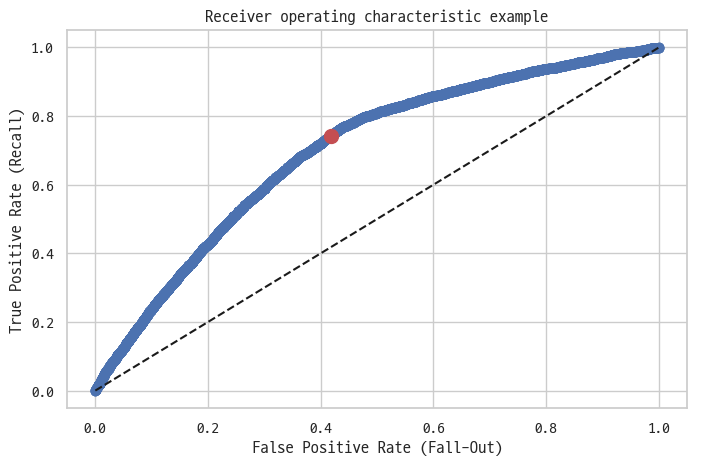

In [364]:
plt.plot(fpr, tpr, 'o-', label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.plot([fallout], [recall], 'ro', ms=10)
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic example')
plt.show()

### AUC

In [365]:
auc(fpr, tpr)

0.697356861732741

### Decision tree 모형

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
tree1 = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0).fit(X_samp, y_samp)

In [ ]:
pd.DataFrame(tree1.feature_importances_, index=X_train.columns, columns= ['importance']).sort_values(by="importance", ascending=False)

In [ ]:
tree2 = ExtraTreesClassifier(max_depth=10, random_state=0).fit(X_samp, y_samp)

In [ ]:
pd.DataFrame(tree2.feature_importances_, index=X_train.columns, columns= ['importance']).sort_values(by="importance", ascending=False)

In [ ]:
y_pred = tree1.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred, labels=["Yes", "No"])

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
param_grid = {"max_depth": np.linspace(1, 100, 20)}

In [ ]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0) ,param_grid=param_grid, scoring="accuracy", cv=10, n_jobs=2)

In [ ]:
%%time
gs = gs.fit(X_samp, y_samp)

In [ ]:
gs.best_score_

In [ ]:
gs.best_params_

In [ ]:
from sklearn.naive_bayes import GaussianNB
model_norm = GaussianNB().fit(X_samp, y_samp)

In [ ]:
y_pred = model_norm.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred, labels=["Yes", "No"])

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.naive_bayes import BernoulliNB
model_bern = BernoulliNB().fit(X_samp, y_samp)

In [ ]:
y_pred = model_bern.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred, labels=["Yes", "No"])

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))